In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('13015_2008_50_MOESM3_ESM.csv', delimiter=',')

# **data** – column layout

| **Col. #** | **Header**          | **Data type / range**                                   | **Meaning**                                                                                         |
|-----------:|--------------------|---------------------------------------------------------|------------------------------------------------------------------------------------------------------|
| 1          | `marker_ID`        | *int* (1 – 837)                                         | Running index of metabolite candidate                                                                |
| 2          | `prototype_ID`     | *int* (1 – 33)                                          | 1-D SOM prototype (cluster) assigned to the feature                                                  |
| 3          | `block_ID`         | *int* (1 – 6)                                           | Biological “block” label (A – F) grouping adjacent prototypes                                        |
| 4          | `mz`               | *float*                                                | Experimental mass-to-charge ratio (m/z)                                                              |
| 5          | `rt`               | *float* (minutes)                                      | Chromatographic retention time                                                                       |
| 6 – 77     | `intensity_<cond>` | *float* (intensity units); 72 columns in total          | Peak intensities for **9 replicates × 8 conditions** (see order below)                               |

### Order of the 72 intensity columns

1. `wt_0h_rep1` … `wt_0h_rep9`  
2. `wt_0.5h_rep1` … `wt_0.5h_rep9`  
3. `wt_2h_rep1` … `wt_2h_rep9`  
4. `wt_5h_rep1` … `wt_5h_rep9`  
5. `dde2_0h_rep1` … `dde2_0h_rep9`  
6. `dde2_0.5h_rep1` … `dde2_0.5h_rep9`  
7. `dde2_2h_rep1` … `dde2_2h_rep9`  
8. `dde2_5h_rep1` … `dde2_5h_rep9`

*(wt = wild-type Col-0,  dde2 = jasmonate-deficient mutant; times are hours post-wounding)*



## Task 2a

In [3]:
# columns 6 to 77 = 72 columns
x_data = data[:, 5:77]
# transposing the columns into a data matrix as rows
x_data_mat = x_data.transpose()
print(x_data_mat.shape)

(72, 837)


In [4]:
def power_method(x_data_mat, n_evs, tol=1e-10, max_iter=100): # for sample pca we set cov bias to false
    """
    Computing several eigenvectors without np.linalg.eig

    Parameters:
    x_data_mat : The data matrix (rows = samples), assumed already mean‐centered or we will center it inside the function.
    n_evs : Number of leading eigen values/vecs to calculate.
    tol : Convergence tolerance on ||v_new - v_old||.
    max_iter : Maximum number of inner iterations.

    Returns:
    eigvals : The leading eigenvalues in descending order.
    eigvecs : Corresponding eigenvectors.
    """
    # centering the data
    X = x_data_mat - x_data_mat.mean(axis=0, keepdims=True)
    # initial covariance
    C = np.cov(X, bias=True, rowvar=False)

    eigvals_arr = [] # shape is (n_evs, )
    eigvecs_arr = [] # shape is (n_evs, n_dims)

    for k in range(n_evs):
        # random initial unit vector
        v = np.random.randn(C.shape[0])
        v /= np.linalg.norm(v)

        # power method on current C
        for i in range(max_iter):
            w     = C @ v
            lambda_   = np.linalg.norm(w)
            v_new = w / lambda_

            # checking convergence
            if np.linalg.norm(v_new - v) < tol:
                break
            v = v_new

        # storing the converged eigenpair
        eigvals_arr.append(lambda_)
        eigvecs_arr.append(v_new.copy())

        # removing the found component
        C = C - lambda_ * np.outer(v_new, v_new)

    return np.array(eigvals_arr), np.vstack(eigvecs_arr)

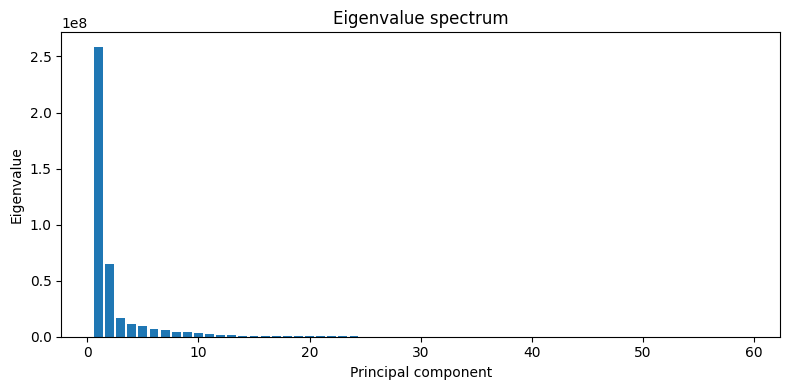

≥70 % var with  2 components
≥90 % var with  5 components


In [5]:
eigvals, eigvecs = power_method(x_data_mat, n_evs = 59, tol=1e-8, max_iter=100)

# Sorting the eigvalues
order = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[order], eigvecs[order]

# Explain variance spectrum
explained_var = eigvals / eigvals.sum()
cum_var = np.cumsum(explained_var)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, 60), eigvals[:59])
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue spectrum')
plt.tight_layout()
plt.show()

# number of PCs for >= 70 % / >= 90 %
n70 = np.searchsorted(cum_var, 0.70) + 1
n90 = np.searchsorted(cum_var, 0.90) + 1
print(f'≥70 % var with  {n70} components')
print(f'≥90 % var with  {n90} components')

# Task 2b

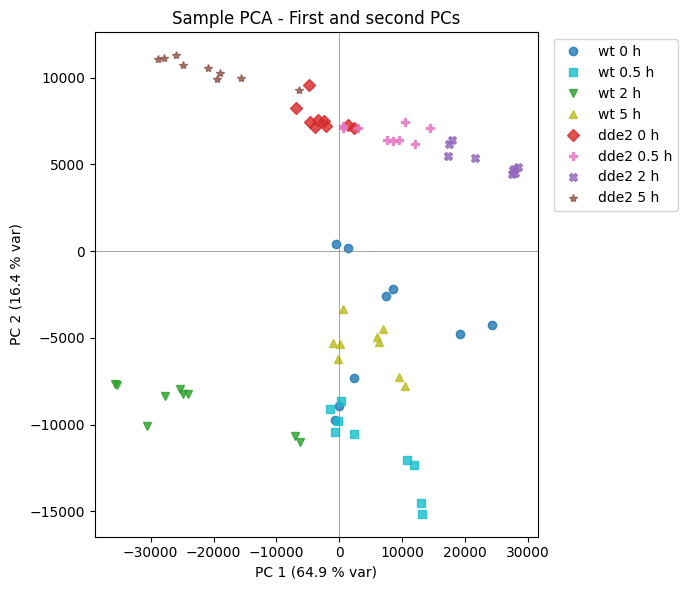

In [6]:
# Projecting Data onto first two PCs
Xc = x_data_mat - x_data_mat.mean(axis=0, keepdims=True)
Z  = Xc @ eigvecs[:2].T      # shape: (n_genes, 2)

# Scatter colored by label
cond_names   = ["wt 0 h",   "wt 0.5 h", "wt 2 h",   "wt 5 h",
                "dde2 0 h", "dde2 0.5 h", "dde2 2 h", "dde2 5 h"]
colors       = ["tab:blue", "tab:cyan",  "tab:green", "tab:olive",
                "tab:red",  "tab:pink",  "tab:purple", "tab:brown"]
markers      = ["o", "s", "v", "^", "D", "P", "X", "*"]

fig, ax = plt.subplots(figsize=(7, 6))
for i, (name, c, m) in enumerate(zip(cond_names, colors, markers)):
    rows = slice(i*9, (i+1)*9)           # 9 replicas
    ax.plot(Z[rows, 0],
            Z[rows, 1],
            linestyle="none", marker=m, color=c, label=name, alpha=0.8)

ax.set_xlabel("PC 1 (%.1f %% var)" % (100 * (eigvals[0] / eigvals.sum())))
ax.set_ylabel("PC 2 (%.1f %% var)" % (100 * (eigvals[1] / eigvals.sum())))
ax.set_title("Sample PCA - First and second PCs")
ax.axhline(0, color="grey", linewidth=.5); ax.axvline(0, color="grey", linewidth=.5)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Interpretation**

* The **vertical split (PC 2)** cleanly separates wild-type and mutant samples, confirming genotype is the second-strongest source of variance.  
* The **horizontal spread (PC 1)** visualises the wound-response dynamics, with wild-type showing a progressive shift and dde2 showing a delayed, weaker pattern.  
* Tight nine-point clusters for each condition indicate little technical noise.

**Take away**: The first two PCs (> 81 % total variance) are enough to disentangle both **who** (genotype) and **when** (post-wounding time) for every LC-MS run in the experiment.

## Task 2c

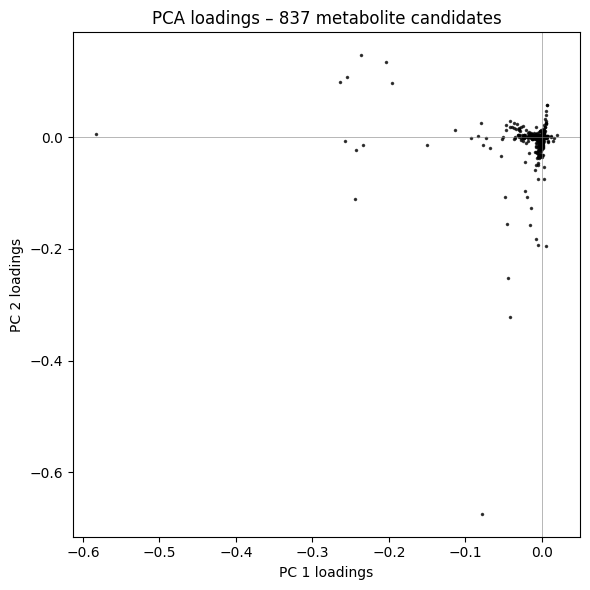

In [7]:
loadings = eigvecs[:2, :].T          # shape = (837 candidates, 2 PCs)

# 2) quick scatter-plot
plt.figure(figsize=(6,6))
plt.plot(loadings[:,0], loadings[:,1], "k.", markersize=3, alpha=0.7)
plt.axhline(0, color="grey", linewidth=.4)
plt.axvline(0, color="grey", linewidth=.4)
plt.xlabel("PC 1 loadings")
plt.ylabel("PC 2 loadings")
plt.title("PCA loadings – 837 metabolite candidates")
plt.tight_layout()
plt.show()

#### we use the loadings plot to spot single high-impact outliers, but rely on more dedicated clustering or SOM visualisations to uncover coherent groups of marker candidates.

#### why?

- Because the first two PCs summarise only two broad directions in the data, most metabolites collapse into a single fuzzy knot near the origin. Variables that form meaningful biological clusters in the full-dimensional space project onto almost the same spot here and therefore cannot be separated visually.


## Task 3a

In [8]:
def column_norm (x_data, ord=2, center=False, eps=1e-12): # ord=2 for euclidean unit norm
    Xc = x_data - x_data.mean(axis=0, keepdims=True) if center else x_data.copy()
    norms = np.linalg.norm(Xc, ord=ord, axis=0, keepdims=True)
    return Xc / (norms + eps)

def row_norm (x_data, ord=2, center=False, eps=1e-12):
    Xc = x_data - x_data.mean(axis=1, keepdims=True) if center else x_data.copy()
    norms = np.linalg.norm(Xc, ord=ord, axis=1, keepdims=True)
    return Xc / (norms + eps)


In [9]:
x_column = column_norm(x_data, ord=2, center=False).transpose()
x_row = row_norm(x_data, ord=2, center=False).transpose()


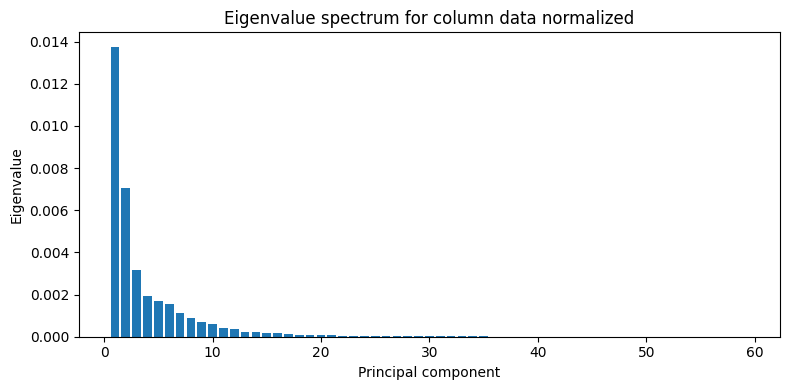

≥70 % var with  4 components
≥90 % var with  9 components


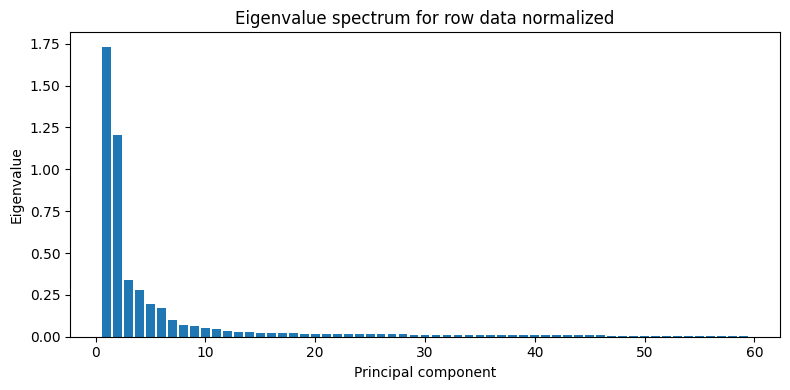

≥70 % var with  4 components
≥90 % var with  15 components


In [23]:
eigvals_c, eigvecs_c = power_method(x_column, n_evs = 59, tol=1e-10, max_iter=100)
eigvals_r, eigvecs_r = power_method(x_row, n_evs = 59, tol=1e-10, max_iter=100)

#x_column
# Sorting the eigvalues
order_c = np.argsort(eigvals_c)[::-1]
eigvals_c, eigvecs_c = eigvals_c[order], eigvecs_c[order]

# Explain variance spectrum
explained_var_c = eigvals_c / eigvals_c.sum()
cum_var_c = np.cumsum(explained_var_c)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, 60), eigvals_c[:59])
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue spectrum for column data normalized')
plt.tight_layout()
plt.show()

# number of PCs for >= 70 % / >= 90 %
n70_c = np.searchsorted(cum_var_c, 0.70) + 1
n90_c = np.searchsorted(cum_var_c, 0.90) + 1
print(f'≥70 % var with  {n70_c} components')
print(f'≥90 % var with  {n90_c} components')

#x_row
# Sorting the eigvalues
order_r = np.argsort(eigvals_r)[::-1]
eigvals_r, eigvecs_r = eigvals_r[order], eigvecs_r[order]

# Explain variance spectrum
explained_var_r = eigvals_r / eigvals_r.sum()
cum_var_r = np.cumsum(explained_var_r)


plt.figure(figsize=(8, 4))
plt.bar(np.arange(1, 60), eigvals_r[:59])
plt.xlabel('Principal component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue spectrum for row data normalized')
plt.tight_layout()
plt.show()

# number of PCs for >= 70 % / >= 90 %
n70_r = np.searchsorted(cum_var_r, 0.70) + 1
n90_r = np.searchsorted(cum_var_r, 0.90) + 1
print(f'≥70 % var with  {n70_r} components')
print(f'≥90 % var with  {n90_r} components')

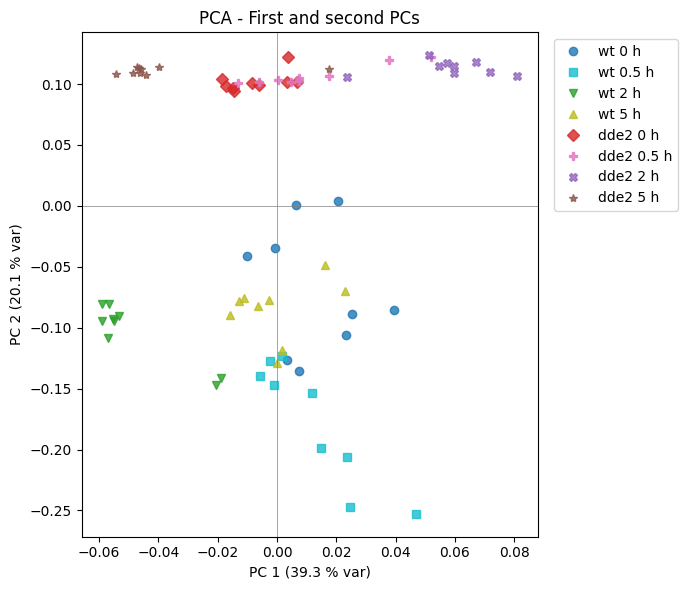

In [24]:
# Projecting normalized column Data onto first two PCs
Xc = x_column - x_column.mean(axis=0, keepdims=True)
Z  = Xc @ eigvecs[:2].T      # shape: (n_genes, 2)

# Scatter colored by label
cond_names   = ["wt 0 h",   "wt 0.5 h", "wt 2 h",   "wt 5 h",
                "dde2 0 h", "dde2 0.5 h", "dde2 2 h", "dde2 5 h"]
colors       = ["tab:blue", "tab:cyan",  "tab:green", "tab:olive",
                "tab:red",  "tab:pink",  "tab:purple", "tab:brown"]
markers      = ["o", "s", "v", "^", "D", "P", "X", "*"]

fig, ax = plt.subplots(figsize=(7, 6))
for i, (name, c, m) in enumerate(zip(cond_names, colors, markers)):
    rows = slice(i*9, (i+1)*9)           # 9 replicas
    ax.plot(Z[rows, 0],
            Z[rows, 1],
            linestyle="none", marker=m, color=c, label=name, alpha=0.8)

ax.set_xlabel("PC 1 (%.1f %% var)" % (100 * (eigvals_c[0] / eigvals_c.sum())))
ax.set_ylabel("PC 2 (%.1f %% var)" % (100 * (eigvals_c[1] / eigvals_c.sum())))
ax.set_title("PCA - First and second PCs")
ax.axhline(0, color="grey", linewidth=.5); ax.axvline(0, color="grey", linewidth=.5)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

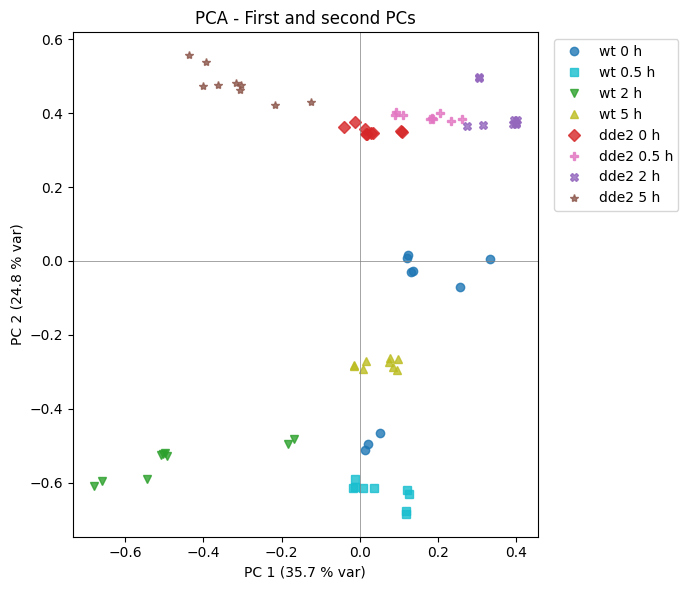

In [25]:
# Projecting normalized row Data onto first two PCs
Xc = x_row - x_row.mean(axis=0, keepdims=True)
Z  = Xc @ eigvecs[:2].T      # shape: (n_genes, 2)

# Scatter colored by label
cond_names   = ["wt 0 h",   "wt 0.5 h", "wt 2 h",   "wt 5 h",
                "dde2 0 h", "dde2 0.5 h", "dde2 2 h", "dde2 5 h"]
colors       = ["tab:blue", "tab:cyan",  "tab:green", "tab:olive",
                "tab:red",  "tab:pink",  "tab:purple", "tab:brown"]
markers      = ["o", "s", "v", "^", "D", "P", "X", "*"]

fig, ax = plt.subplots(figsize=(7, 6))
for i, (name, c, m) in enumerate(zip(cond_names, colors, markers)):
    rows = slice(i*9, (i+1)*9)           # 9 replicas
    ax.plot(Z[rows, 0],
            Z[rows, 1],
            linestyle="none", marker=m, color=c, label=name, alpha=0.8)

ax.set_xlabel("PC 1 (%.1f %% var)" % (100 * (eigvals_r[0] / eigvals_r.sum())))
ax.set_ylabel("PC 2 (%.1f %% var)" % (100 * (eigvals_r[1] / eigvals_r.sum())))
ax.set_title("PCA - First and second PCs")
ax.axhline(0, color="grey", linewidth=.5); ax.axvline(0, color="grey", linewidth=.5)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### This matches fig 11 in the paper

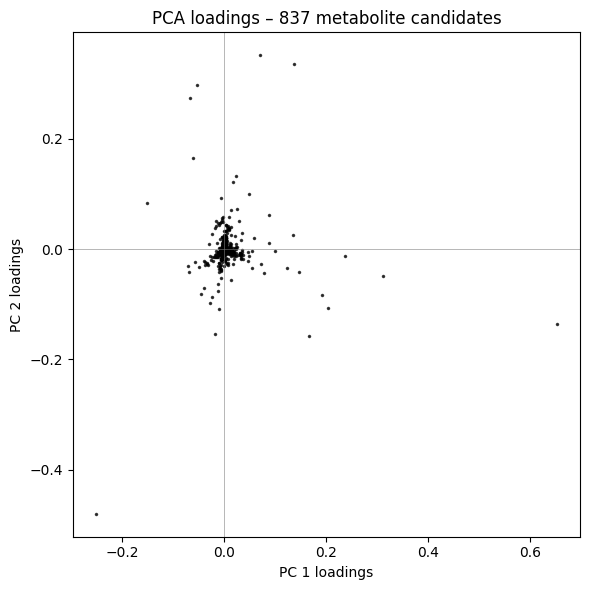

In [13]:
loadings_c = eigvecs_c[:2, :].T       

# 2) quick scatter-plot
plt.figure(figsize=(6,6))
plt.plot(loadings_c[:,0], loadings_c[:,1], "k.", markersize=3, alpha=0.7)
plt.axhline(0, color="grey", linewidth=.4)
plt.axvline(0, color="grey", linewidth=.4)
plt.xlabel("PC 1 loadings")
plt.ylabel("PC 2 loadings")
plt.title("PCA loadings – 837 metabolite candidates")
plt.tight_layout()
plt.show()

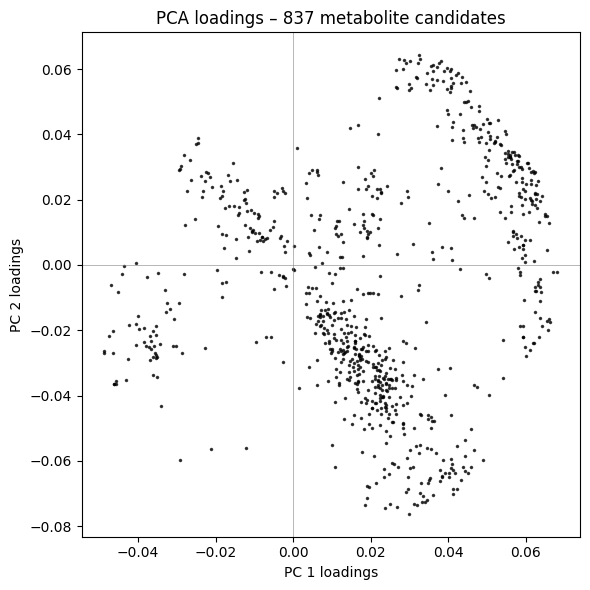

In [14]:
loadings_r = eigvecs_r[:2, :].T       

# 2) quick scatter-plot
plt.figure(figsize=(6,6))
plt.plot(loadings_r[:,0], loadings_r[:,1], "k.", markersize=3, alpha=0.7)
plt.axhline(0, color="grey", linewidth=.4)
plt.axvline(0, color="grey", linewidth=.4)
plt.xlabel("PC 1 loadings")
plt.ylabel("PC 2 loadings")
plt.title("PCA loadings – 837 metabolite candidates")
plt.tight_layout()
plt.show()

| Key point | **Unnormalised** | **Column normalised**<br>(sample scaling) | **Row normalised**<br>(feature scaling) |
|-----------|------------------|-------------------------------------------|-----------------------------------------|
| **What is scaled?** | nothing | each sample column by unit norm | each metabolite row by unit norm |
| **Main effect on variance** | Dominated by high-abundance peaks | Removes total ion differences between runs | Removes intensity differences between peaks |
| **PC scores (samples)** | Good separation, but distances inflated by run size | Separation keeps shape info, run-size bias gone | Similar separation, sometimes tighter clusters |
| **PC loadings (variables)** | Few strong outliers, most points at origin | Very tight cloud, only a handful stand out | Broad ring/arms, many peaks now visible |


In [15]:
print(x_column.shape)
print(x_row.shape)
print(loadings_r.shape)

x_column_T = x_column.T
print(x_column_T.shape)

(72, 837)
(72, 837)
(837, 2)
(837, 72)


In [16]:
# cluster A: upper right corner
mask_A = (loadings_r[:,0] > 0.02) & (loadings_r[:,1] > 0.02)

# cluster B: lower right corner
mask_B = (loadings_r[:,0] > 0.02) & (loadings_r[:,1] < -0.02)

In [17]:
print(mask_A.sum(), "candidates in cluster A")
print(mask_B.sum(), "candidates in cluster B")

172 candidates in cluster A
194 candidates in cluster B


In [18]:
# mean across 9 replicates per condition
cond_means = np.stack([x_column_T[:, i*9:(i+1)*9].mean(axis=1)
                       for i in range(8)], axis=1)          # (837 × 8)

In [19]:
print(mask_A.shape)
print(mask_B.shape)
print(x_column.shape)
print(cond_means.shape)

(837,)
(837,)
(72, 837)
(837, 8)


In [20]:
profiles_A = cond_means[mask_A]
profiles_B = cond_means[mask_B]

In [21]:
profiles_A = profiles_A / (np.linalg.norm(profiles_A, axis=1, keepdims=True) + 1e-12)
profiles_B = profiles_B / (np.linalg.norm(profiles_B, axis=1, keepdims=True) + 1e-12)

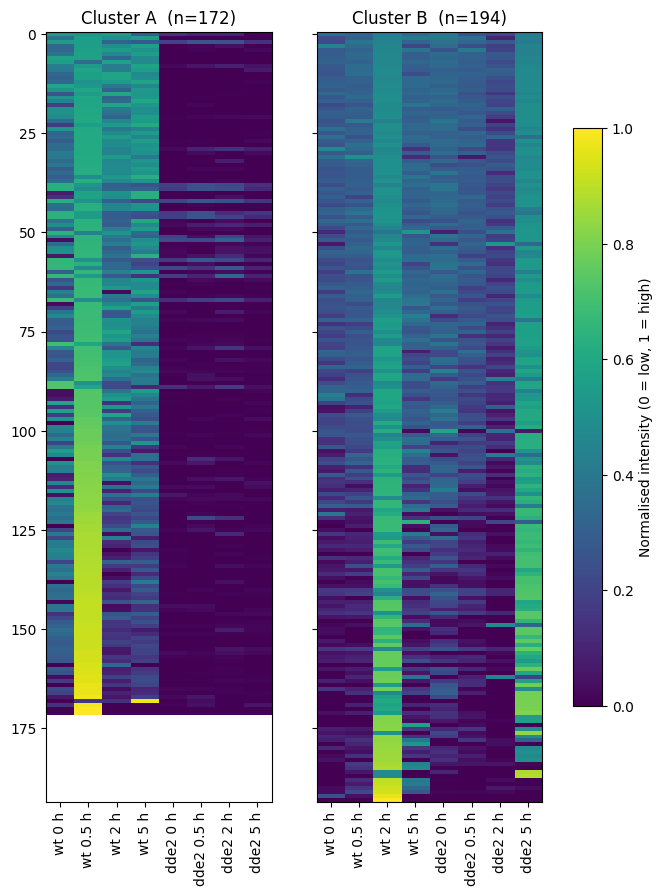

In [22]:
def show_cluster(ax, M, title):
    """plot a cluster; rows are re-ordered for clarity"""
    order = np.argsort(M.max(axis=1))          # weak to strong
    im = ax.imshow(M[order], aspect='auto',
                   cmap='viridis', vmin=0, vmax=1)
    ax.set_xticks(range(8))
    ax.set_xticklabels(cond_names, rotation=90)
    ax.set_title(f"{title}  (n={M.shape[0]})")
    return im

fig, axs = plt.subplots(1, 2, figsize=(8, 10), sharey=True)
im1 = show_cluster(axs[0], profiles_A, "Cluster A")
im2 = show_cluster(axs[1], profiles_B, "Cluster B")

# single colour-bar for both panels
cbar = fig.colorbar(im1, ax=axs.ravel(), shrink=0.75)
cbar.set_label("Normalised intensity (0 = low, 1 = high)")


plt.show()



| Cluster | Shared intensity pattern (each row is one metabolite, each column is one condition) | Biological interpretation (compared with Fig. 2 / Table 2 in the paper) |
|---------|---------------------------------|--------------------------------------------------------------|
| **A (n = 172)** | • Bright **single spike at 0.5 h in wild-type** (2nd column, yellow/green).<br>• Fades by 2 h and almost absent by 5 h.<br>• Virtually no induction in *dde2* (right-hand four columns stay violet).<br><br>*→ early, wild-type-specific wound burst that is jasmonate-dependent.* | Corresponds to **Block B/C** in the SOM: OPDA, JA precursors and other early WT markers that fail to rise in the *dde2* mutant. |
| **B (n = 194)** | • Dark at 0 h in both genotypes.<br>• Clear peak at **2 h** for *both* wild-type and **especially** *dde2* (turquoise–green stripe in the 3rd and 7th columns).<br>• Signal often remains moderate at 5 h.<br><br>*→ general wound-response features, but slightly stronger / more prolonged in the mutant.* | Matches the paper’s **Blocks D/E/F**: “mutant-enriched, mid-to-late wound markers” that accumulate in *dde2* ≈ 2 h and persist. |
